In this ***Pandas SQL tutorial*** we will be going over how to connect to a Microsoft ***SQL Server***. I have a local installation of SQL Server and we will be going over everything step-by-step.

After we connect to our database, I will be showing you all it takes to ***read sql*** or how to go ***to Pandas from sql***. We will also venture into the possibilities of writing directly to SQL DB via Pandas.

Before we begin let's import all of the necessary libraries. A new library we haven't seen much of is ***pyodbc*** and we use this library to connect to certain databases. I've used it in the past and it has made it relatively easy to connect to mssql.

In [3]:
import pandas as pd
import pyodbc
import sys

Here are the versions of these libraries I am running on. 
> If you are having any issues running the code in this SQL tutorial, check to see if you are using different versions of these libraries.

**Note:** I'm also using Microsoft SQL Server 2012, an older version that you might be on.

In [5]:
print('Python: ' + sys.version.split('|')[0])
print('Pandas: ' + pd.__version__)
print('pyODBC: ' + pyodbc.version)

Python: 3.5.1 
Pandas: 0.23.4
pyODBC: 3.0.10


This tutorial is also available in video form. I try to go in more detail in the notebook but the video is worth watching.

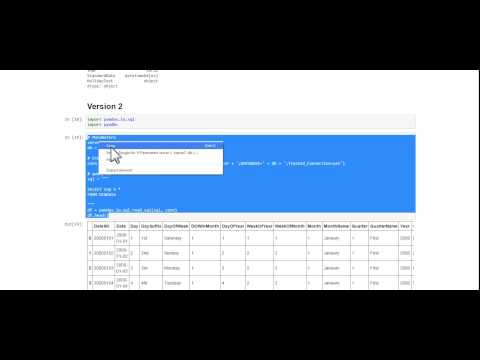

In [30]:
from IPython.display import YouTubeVideo
YouTubeVideo("uoLE14ZLkUM")

<h2>Connect to SQL Server</h2>

Let's head over to SQL server and connect to our Example BizIntel database. On the Connect to Server dialog box, enter your credentials and click the ***Connect*** button as shown in the figure below. If you have a local server set up, you won't need any credentials. If you are on a company server, you most likely will be required to enter a user name and password.

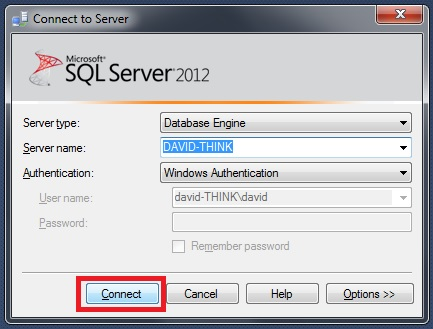

In [6]:
from IPython.display import Image
Image(filename="sql-server-login.jpg")

After you successfully connect, go to the top left of your screen and under the ***Object Explorer*** find the folder named ***Databases***. Expand this folder to see what databases we have available to us.  

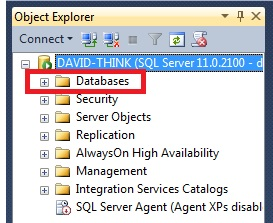

In [7]:
Image(filename="open-database.jpg")

I went ahead and expanded the only database we have available to us, the BizIntel db. I then expanded the ***Tables*** folder and we can see we have 4 tables available to us.

* data
* pmthistory
* rateplan
* users

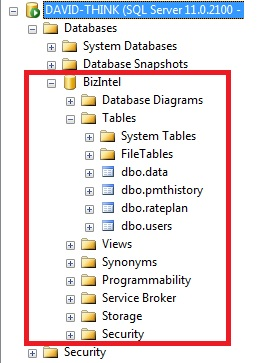

In [8]:
Image(filename="bizintel-db-tables.jpg")

Let's query the table named ***data*** and see what it looks like, this is the table we will query using Pandas shortly. As you can see, we have a tiny table with just ***22 rows***. It has three columns named ***Date, Symbol, and Volume***. I think the data may have come from a client I had a long time ago. It consist of stock data and the related volume. And yes, I de-identified the stock symbols here. For this tutorial it doesn't matter what the data looks like, but I thought I share that bit of information.

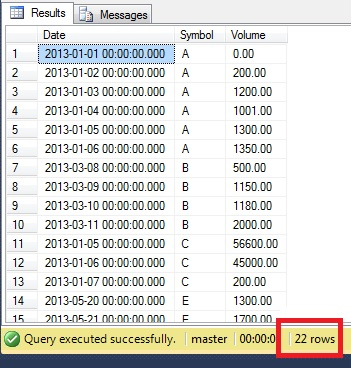

In [10]:
Image(filename="query-data-table.jpg")

<h2>Create a Pandas SQL Query</h2>

Now we finally get to what we are after. How in the world do we query a microosft sql server database from Pandas? Like I mentioned to you ealier, we are going to leverage the pyODBC library. With a one liner, we are going to be able to connect to the mssql server. After we are connected, we then use the Pandas ***read_sql*** function to send a query to the server and place the results back into a Pandas dataframe. 

I placed the servername and database names in a Python dictionary. You don't have to do this, you could have simply hard coded the values or placed them in two separate varibles. Placing them in a dict seems cleaner to me. If you were creating an application, another option would be to place these parameters in a JSON file. 

The connection string is a bit tricky. It actually took me many many tries to get it working. First of all, it's a string you have to manufacture and it is very picky. Go to [connecting to various databases](https://github.com/mkleehammer/pyodbc/wiki/Connecting-to-databases) for more information. For examples of SQL Sever connection strings go to [www.connectionstrings.com](https://www.connectionstrings.com/sql-server).

After you get over that hurdle, the rest is pretty straight forward. You write your sql statement or sql query and pass it to Pandas along with the connection string. For the example below, I simply selected the top 5 rows of the data table. 

In [14]:
# parameters
DB = {'servername': 'DAVID-THINK',
      'database': 'BizIntel'}

# create the connection
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

# query db
sql = """

SELECT top 5 *
FROM data

"""
df = pandas.read_sql(sql, conn)
df.head()

,Date,Symbol,Volume
0,2013-01-01,A,0.0
1,2013-01-02,A,200.0
2,2013-01-03,A,1200.0
3,2013-01-04,A,1001.0
4,2013-01-05,A,1300.0


Like I mentioned earlier the ***.read_sql*** function will return a dataframe. This makes it very convinient and I have not encountered any datatype issues. Since we are pulling directly from the sql server database, Pandas should be able to correctly map the right datatype to the right column.

As shown below, you can see date, text, and numeric data types were applied as expected.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
Date      5 non-null datetime64[ns]
Symbol    5 non-null object
Volume    5 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 200.0+ bytes


<h2>Pandas to SQL</h2>

Going from ***Pandas to SQL*** is another story. What do we mean by going from Pandas to SQL? Let's say we wanted to add a new table to our database. Let's say we created a brand new dataframe and then wanted to add the contents of the dataframe to our SQL Server database. Can we actually do this? YES!

Now it does require us to import yet another library called ***sqlalchemy*** but after you see the code, it isn't so bad. And for the record, it did take me many tries and Googling to get this all working.

Let's create a very basic dataframe and call it df2 as shown below.

In [16]:
df2 = pd.DataFrame({'key':['a','a','b'],
                    'val':[435,7,6]})
df2

,key,val
0,a,435
1,a,7
2,b,6


Now that we have our dataframe ready to go, we will need to import the sqlalchemy library I mentioned earlier. The reason we need this library is that the ***to_sql*** Pandas function is set up for sqlalchemy and sqlite only. If you try to use it with just pyODBC it will fail. At least it did when I gave it a try. 

The parameters dict is similar to the one we created a few code cells above, but we have added driver to the list. The good news is that the mechanics are essentially identical to the ***read_sql*** function. We create a connction object or string and tell Pandas to either read in data from sql server or write data to sql server. 

We also passed an additional parameter called ***index*** and we did this so that we don't import the index as an extra column. It is included by default, so make a mental note when you are importing your own data.

I also added the print statement at the bottom since to_sql will not return anything if the insert to sql srever was successful. 

In [24]:
from sqlalchemy import create_engine

# parameters
DB = {'servername': 'DAVID-THINK',
      'database': 'BizIntel',
      'driver': 'driver=SQL Server Native Client 11.0'}

# create the connection
engine = create_engine('mssql+pyodbc://' + DB['servername'] + '/' + DB['database'] + "?" + DB['driver'])

# add table to sql server
df2.to_sql('test', index=False, con=engine)

print('Worked!')

Worked!


If we go back to SQL Server, we will see a new table was added to the BizIntel database and the results match our df2 dataframe. Pretty easy. That is it for now, I hope you enjoyed this quick tutorial. Now it is very important you try this at work or at home. Unless you actually try to replicate my results on your own SQL Server and your own data, you won't learn. It is after going through tons of trial and error that you will get good at this Pandas thing. 

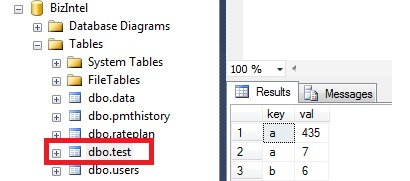

In [28]:
Image(filename="pandas-to-sql.jpg")

<p class="text-muted">This tutorial was created by <a href="http://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>